In [14]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from qutip import *

In [15]:
def Hamil( g, eta, ot_vec , ge, a, Del_c ):
    # input: relevant parameters and operators
    # output: Hamiltonian operator
    Omega = ot_vec[0]
    theta = ot_vec[1]

    H0 = Del_c * a.dag() * a + Del_c * ge.dag() * ge
    H1 = (a.dag() * ge + a * ge.dag()) 
    H2 = (a + a.dag())
    H3 = (np.exp(1j*theta) * ge + np.exp(-1j*theta) * ge.dag()) 

    H = H0 + g * H1 + eta * H2 + Omega * H3

    return H

def Liouv( H, C1, C2, C1dC1, C2dC2 ):
    # input: relevant operators and Hamiltonian
    # output: Liouvillian
    LH = -1j * (spre(H) - spost(H))
    L1 = spre(C1)*spost(C1.dag()) - 0.5*spre(C1dC1) - 0.5*spost(C1dC1)
    L2 = spre(C2)*spost(C2.dag()) - 0.5*spre(C2dC2) - 0.5*spost(C2dC2)

    L = LH+L1+L2
    return L 

def correlation_ss_gtt(H, tlist, c_ops, a_op, b_op, c_op, d_op, rho0=None):
    if rho0 == None:
        rho0 = steadystate(H, c_ops)

    return mesolve(H, d_op * rho0 * a_op, tlist, c_ops, [b_op * c_op]).expect[0]

In [16]:
## PARAMETERS ##
kappa = 20*2*np.pi      # cavity dissipation rate (GHz)
gamma = 2*np.pi         # atom dissipation rate (GHz)
N = 5                   # number of cavity fock states 
g  = 2*kappa            # QD-cavity coupling strength
eta = 0.1*kappa         # weak cavity coupling strength

## OPERATORS ##
# Ladder operators
a  = tensor(destroy(N), qeye(2))    # a - cavity lowering operator
sm = tensor(qeye(N), sigmam())    # sigma - atomic lowering operator

# Collapse Operators
C1 = np.sqrt(kappa)*a
C2 = np.sqrt(gamma)*sm
C1dC1 = C1.dag() * C1
C2dC2 = C2.dag() * C2

## ARRAYS ##
Del_c_vec = np.linspace(-2,2,201) * g
taulist = np.linspace(0,20,200)

In [17]:

## CALCULATION ##
ot_lst = [[0.124*g,0.082*np.pi],[0.124*g,(1-0.082)*np.pi],[0,0]]
count_lst = []
g2_lst = []

H1 = (a.dag() * sm + a * sm.dag()) 
H2 = (a + a.dag())

for ot_vec in ot_lst:
    count_vec = []
    g2_vec = []
    
    for Del_c in Del_c_vec:
        H = Hamil( g, eta, ot_vec , sm, a, Del_c )
        L = Liouv( H, C1, C2, C1dC1, C2dC2 )
        rhoss = steady(L)

        n = expect(C1dC1,rhoss)
        G2 = correlation_ss_gtt(H, taulist, [C1,C2], a.dag(), a.dag(), a, a, rho0=rhoss)
        g2 = G2[0]/n**2

        count_vec.append(n)
        g2_vec.append(g2)
    
    count_lst.append(count_vec)
    g2_lst.append(g2_vec)

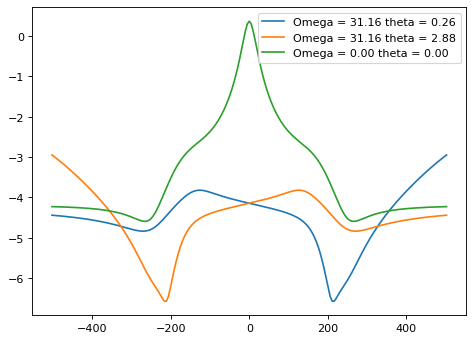

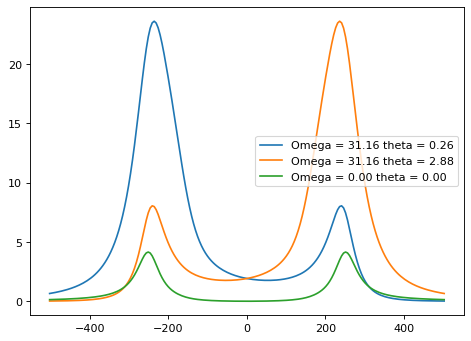

In [18]:
fig1, ax1 = plt.subplots(1, 1, figsize=(7,5), dpi=80)
for i in range(len(ot_lst)):
    ax1.plot(Del_c_vec, np.log10(g2_lst[i]), label = 'Omega = {:.2f} theta = {:.2f}'.format(ot_lst[i][0],ot_lst[i][1]))
ax1.legend()

fig2, ax2 = plt.subplots(1, 1, figsize=(7,5), dpi=80)
for i in range(len(ot_lst)):
    ax2.plot(Del_c_vec, count_lst[i], label = 'Omega = {:.2f} theta = {:.2f}'.format(ot_lst[i][0],ot_lst[i][1]))
ax2.legend()